# Fusion of IMU and Audio features
## Without doing time shifting
## Training on Synchronized Audio and IMU data

## IMU and Audio data is concatenated at an intermediate layer and then prediction is made

In [1]:
import numpy as np
import scipy.io

from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint


import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K

from matplotlib import pyplot as plt
from PIL import Image as img_PIL


# random seed.
rand_seed = 2

from numpy.random import seed
seed(rand_seed)
from tqdm.keras import TqdmCallback
import tensorflow
tensorflow.random.set_seed(rand_seed)

In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=10


    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features

In [3]:
path='C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/data/'

def get_train_and_validate_data(path=path):
    Train_data = np.load(path+'Data_train_all.npz')
    Train_data=np.load(path+'train_5000.npz')
    Features_imu=np.asarray(Train_data['arr_0'],dtype=np.float64)
    Labels=Train_data['arr_1']
    Features_audio=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    
    randomize = np.arange(len(Labels))
    np.random.shuffle(randomize)
    
    Labels = Labels[randomize]
    Features_audio = Features_audio[randomize]
    Features_imu = Features_imu[randomize]
    
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    new_Labels = np.split(Labels,[Labels.shape[0] - 2000])
    new_Features_audio = np.split(Features_audio,[Features_audio.shape[0] - 2000])
    Features_imu = np.split(Features_imu,[Features_imu.shape[0] - 2000])
    
    return new_Labels[0],new_Features_audio[0],Features_imu[0],new_Labels[1],new_Features_audio[1],Features_imu[1]


def get_test_data(path=path):
    Train_data = np.load(path+'Data_test_71.pkl',allow_pickle=True)
    Labels = Train_data[1]
    Features_audio = Train_data[2]
    Features_imu = np.asarray(Train_data[0],dtype=np.float64)

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 
    
    return Labels,Features_audio,Features_imu

In [4]:
Labels,Features_audio,Features_imu,Labels2,Features_audio2,Features_imu2 = get_train_and_validate_data()
print(Labels.shape,Features_audio.shape,Features_imu.shape)
print('Train Classes distribution: ',np.sum(Labels, axis = 0))

print(Labels2.shape,Features_audio2.shape,Features_imu2.shape)
print('Validate Classes distribution: ',np.sum(Labels2, axis = 0))

Labels3,Features_audio3,Features_imu3 = get_test_data()
print(Labels3.shape,Features_audio3.shape,Features_imu3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis = 0))

(3000, 7) (3000, 193) (3000, 1, 40, 12)
Train Classes distribution:  [440. 626. 324. 458. 326. 434. 392.]
(2000, 7) (2000, 193) (2000, 1, 40, 12)
Validate Classes distribution:  [320. 368. 222. 322. 206. 298. 264.]
(1377, 7) (1377, 193) (1377, 1, 40, 12)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


# Combined Model: Audio + IMU

In [5]:
input_audio = keras.layers.Input(shape=(193,))
A1 = keras.layers.Dense(256, activation='relu')(input_audio)
A2 = keras.layers.Dense(256, activation='relu')(A1)
D1 = keras.layers.Dropout(0.3)(A2)
A5 = keras.layers.Dense(128, activation='relu')(D1)



num_feat_map=32
_, dim, win_len, _, = Features_imu.shape
input_imu = keras.layers.Input(shape=(dim, win_len, 12))

I1 = keras.layers.Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 padding='same')(input_imu)
I2=keras.layers.MaxPooling2D(pool_size=(1, 2))(I1)

I3 = keras.layers.Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 padding='same')(I2)
I4=keras.layers.MaxPooling2D(pool_size=(1, 2))(I3)
I5=keras.layers.Flatten()(I4)

I6= keras.layers.Dense(256, activation='relu')(I5)
D2 = keras.layers.Dropout(0.3)(I6)

I7= keras.layers.Dense(128, activation='relu')(D2)


# equivalent to added = keras.layers.add([x1, x2])
C1 =keras.layers.concatenate([A5, I7], axis=-1)


C3= keras.layers.Dense(64, activation='relu')(C1)

out = keras.layers.Dense(7, activation='softmax')(C3)

model = keras.models.Model(inputs=[input_audio, input_imu], outputs=out)


In [6]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 40, 12)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1, 40, 32)    1952        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 1, 20, 32)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 20, 32)    5152        max_pooling2d[0][0]              
_______________________________________________________________________________________

In [7]:
model_path = 'C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models/imu_audio_combined_model_checkpoint'

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_accuracy' ,save_best_only=True, save_weights_only=False)
earlystopper = EarlyStopping(monitor='val_accuracy',patience=5)

In [8]:
batch_size = 128
epochs = 100
from keras import optimizers
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])

import time
start_time = time.time()

learning_hist = model.fit([Features_audio,Features_imu], Labels,
                    verbose=0,
                    epochs=epochs,
                    shuffle=True,
                    batch_size=batch_size,
                    callbacks=[checkpointer,earlystopper,TqdmCallback(verbose=2)],
                    validation_data=([Features_audio2,Features_imu2], Labels2)
                         
                         )

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00001: val_accuracy improved from -inf to 0.56550, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00002: val_accuracy improved from 0.56550 to 0.73100, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00003: val_accuracy improved from 0.73100 to 0.76800, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00004: val_accuracy improved from 0.76800 to 0.82450, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00005: val_accuracy improved from 0.82450 to 0.86350, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00006: val_accuracy improved from 0.86350 to 0.88300, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00007: val_accuracy improved from 0.88300 to 0.90550, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00008: val_accuracy improved from 0.90550 to 0.91700, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00009: val_accuracy improved from 0.91700 to 0.92800, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00010: val_accuracy did not improve from 0.92800


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00011: val_accuracy improved from 0.92800 to 0.93250, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00012: val_accuracy improved from 0.93250 to 0.93850, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00013: val_accuracy did not improve from 0.93850


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00014: val_accuracy did not improve from 0.93850


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00015: val_accuracy improved from 0.93850 to 0.94600, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00016: val_accuracy improved from 0.94600 to 0.95050, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00017: val_accuracy did not improve from 0.95050


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00018: val_accuracy did not improve from 0.95050


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00019: val_accuracy did not improve from 0.95050


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00020: val_accuracy did not improve from 0.95050


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00021: val_accuracy improved from 0.95050 to 0.95700, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00022: val_accuracy did not improve from 0.95700


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00023: val_accuracy improved from 0.95700 to 0.95750, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00024: val_accuracy improved from 0.95750 to 0.95900, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_checkpoint\assets


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00025: val_accuracy did not improve from 0.95900


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00026: val_accuracy did not improve from 0.95900


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00027: val_accuracy did not improve from 0.95900


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00028: val_accuracy did not improve from 0.95900


  0%|          | 0.00/24.0 [00:00<?, ?batch/s]


Epoch 00029: val_accuracy did not improve from 0.95900
---Time 29.356717586517334 seconds ---


# Accuracies

In [9]:
from keras.models import load_model

model = load_model(model_path)

In [10]:
#Train Accuracy
model.evaluate([Features_audio,Features_imu],Labels)

94/94 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9920


[0.017865633592009544, 0.9919999837875366]

In [11]:
## Valid Accuracy
model.evaluate([Features_audio2,Features_imu2],Labels2)

63/63 [==============================] - 0s 2ms/step - loss: 0.1465 - accuracy: 0.9590


[0.1464768946170807, 0.9589999914169312]

In [12]:
## Test Accuracy
model.evaluate([Features_audio3,Features_imu3],Labels3)

44/44 [==============================] - 0s 2ms/step - loss: 0.1477 - accuracy: 0.9441


[0.14769485592842102, 0.9440813064575195]

# Plotting

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


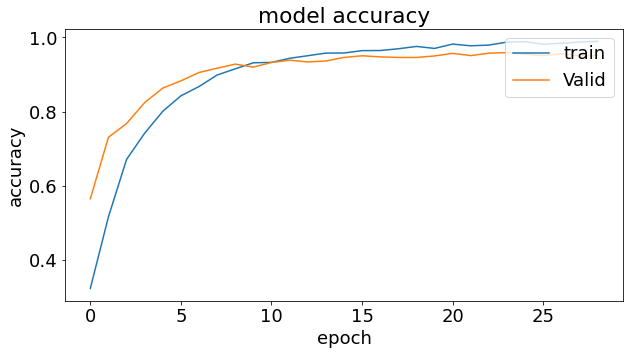

In [13]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['accuracy'])
plt.plot(learning_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

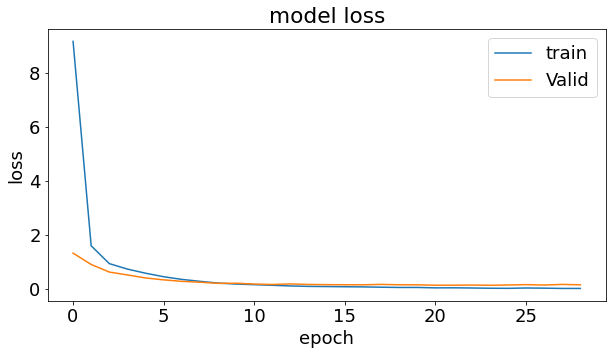

In [14]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()